# Train an RNN to solve a simple memory task via backprop through time in JAX

We only have to write the forward simulation in a JAX-friendly way. Then we can automatically construct the gradient function using JAX's autograd functionality.

The key tricky bit is implementing the for loop, which we will do using jax.lax.scan so that it is compatible with autograd.

In [1]:
from functools import partial
import matplotlib.pyplot as plt
import sys

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, random
from jax.lax import scan

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

print('JAX', jax.__version__, jax.devices())  # check device

JAX 0.4.30 [CpuDevice(id=0)]


## 2-neuron RNN:

$$\tau\frac{d\mathbf{x}}{dt} = -\mathbf{x} + J\phi(\mathbf{x}) + \mathbf{u}(t)$$

$$\phi = \text{tanh}$$

$\mathbf{x} \in \mathbb{R}^2$, $u_1(t) = \delta(t)$, $u_2(t) = 0$.

Simple loss function (goal is for $x_1$ to pass through a target value of 1 at time $T$):

$$\mathcal{L}[J] = [x_1(T) - 1]^2.$$

Initial $J = 0$. We also let $\tau = 10$ms, so that the network has a very short initial response.

The simplest solution is to increase $J_{11}$ to slow down the decay of $x_1$. Can this be learned through BPTT?

## Setup and forward loop

In [2]:
# params
TAU = jnp.array(.01)
PHI = jnp.tanh
TARG = 1  # target

X_0 = jnp.array([0., 0])  # initial x for simulation
J_0 = 0.0*jnp.array([[0, -1.], [1., 0]])  # initial J for learning

DT = jnp.array(.001)

# func to make input time-series
def make_u(T, key_=0):
    T = jnp.array(T)
    t = jnp.arange(0, T, DT)
    
    key = random.key(key_)
    u = jnp.array(0.0)*random.normal(key, (len(t), 2))/jnp.sqrt(DT)  # change prefactor to add (frozen) noise
    u = u.at[1, 0].set(1/DT)  # delta impulse at first timestep
    
    return u, t

# simulation loop function
def f(x_, u_, tau, J):
    x_ = x_ + (DT/tau)*(-x_ + J@PHI(x_) + tau*u_)
    return x_, x_   # to work with syntax of jax.lax.scan

Demo forward loop using scan.

In [3]:
u, t = make_u(T=.1)

# define "partial" version of loop block (fixing other params and taking only prev loop result as input)
f_partial = partial(f, tau=TAU, J=J_0)

# implement the for loop using scan
x = scan(f_partial, X_0, u)[1]

Text(0.089, 0.82, 'Target')

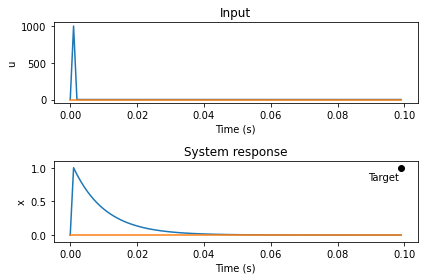

In [4]:
fig, axs = plt.subplots(2, 1, figsize=(6, 4), tight_layout=True)
axs[0].plot(t, u)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('u')
axs[0].set_title('Input')
axs[1].plot(t, x)
axs[1].scatter(t[-1], TARG, c='k')
axs[1].set_ylim(-.1, 1.1)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('x')
axs[1].set_title('System response')
axs[1].text(.089, .82, 'Target')

## Demonstration of vanishing gradient problem

We will now use JAX's autograd function to differentiate through the simulation, which corresponds to back propagation through time.

We will see that as the delay $T$ increases, the differentation of the loss function eventually fails.

In [5]:
ALPHAS = .1*jnp.ones(50)  # learning schedule (constant over 50 epochs)
TS = [.03, .04, .05, .07, .1, .5, 1.]  # delays between input and target

ts_all = []
us_all = []
Js_all = []
losses_all = []
grads_all = []

for T in TS:
    sys.stdout.write(f'T={T}')
    u, t = make_u(T=T)
    
    ts_all.append(t)
    us_all.append(u)

    # define loss function
    def loss_fn(J):
        f_partial = partial(f, tau=TAU, J=J)  
        _, x = scan(f_partial, X_0, u)
        return jnp.abs(x[-1, 0]-TARG)**2

    # get grad func
    def grad_fn(J):
        return grad(loss_fn)(J)

    def train(J, alphas):

        Js = []
        losses = []
        grads = []

        for cepoch, alpha in enumerate(alphas):
            sys.stdout.write('.')

            loss = loss_fn(J)
            losses.append(loss)

            grad = grad_fn(J)
            grads.append(grad)

            J -= alpha*grad
            Js.append(J)

        return Js, losses, grads
    
    Js, losses, grads = train(J_0, ALPHAS)
    
    Js_all.append(Js)
    losses_all.append(losses)
    grads_all.append(grads)
    
    print('')

T=0.03..................................................
T=0.04..................................................
T=0.05..................................................
T=0.07..................................................
T=0.1..................................................
T=0.5..................................................
T=1.0..................................................


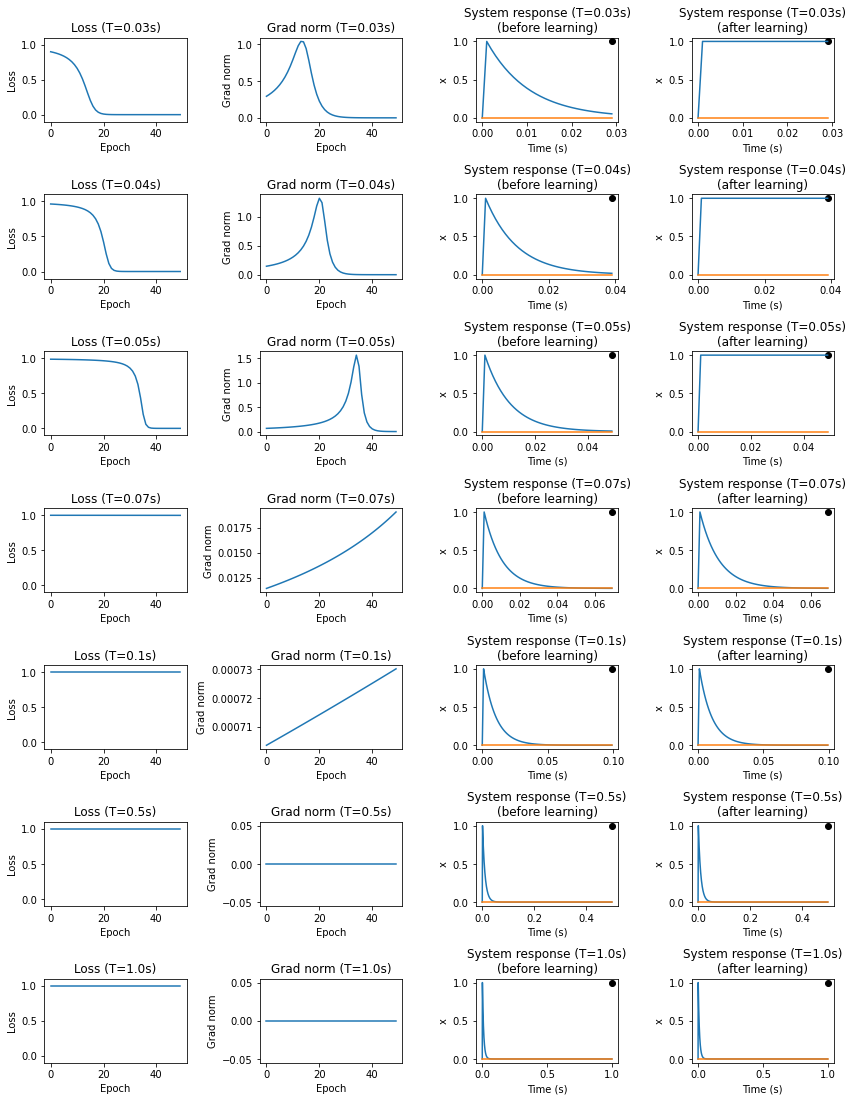

In [6]:
fig, axs = plt.subplots(len(TS), 4, figsize=(12, 2.2*len(TS)), tight_layout=True)
for T, t, u, Js, losses, grads, axs_ in zip(TS, ts_all, us_all, Js_all, losses_all, grads_all, axs):
    
    axs_[0].plot(losses)
    axs_[0].set_ylim(-.1, 1.1)
    axs_[0].set_xlabel('Epoch')
    axs_[0].set_ylabel('Loss')
    axs_[0].set_title(f'Loss (T={T}s)')
    
    axs_[1].plot([jnp.linalg.norm(grad) for grad in grads])
    axs_[1].set_xlabel('Epoch')
    axs_[1].set_ylabel('Grad norm')
    axs_[1].set_title(f'Grad norm (T={T}s)')
    
    x = scan(partial(f, tau=TAU, J=J_0), X_0, u)[1]
    axs_[2].plot(t, x)
    axs_[2].scatter(t[-1], TARG, c='k')
    axs_[2].set_xlabel('Time (s)')
    axs_[2].set_ylabel('x')
    axs_[2].set_title(f'System response (T={T}s)\n(before learning)')
    
    x = scan(partial(f, tau=TAU, J=Js[-1]), X_0, u)[1]
    axs_[3].plot(t, x)
    axs_[3].scatter(t[-1], TARG, c='k')
    axs_[3].set_xlabel('Time (s)')
    axs_[3].set_ylabel('x')
    axs_[3].set_title(f'System response (T={T}s)\n(after learning)')